In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
import os
import pandas as pd 
import warnings
from collections import defaultdict

warnings.filterwarnings('ignore')

fail_list = {'3812734302P240401773', '3812734302P240401779', '3812734302P240401755', '3812734302P240401767', '3812734302P240401795',
             '3812734302P240505509', '3812734302P240505075', '3812734302P240505074', '3812734302P240505994', '3812734302P240506033',
             '3812734302P240505963', '3812734302P240505980', '3812734302P240506037', '3812734302P240506040', '3812734302P240506052',
             '3812734302P240506693', '3812734302P240507614', '3812734302P240507643', '3812734402P240601030', '3812734402P240601682',
             '3812734402P240602196', '3812734402P240603751', '3812734302P240806629', '3812731500P240900681', '3812731500P240900638',
             '3812731500P240900469', '3812731500P240900656', '3812731500P240900539', '3812731500P240900940', '3812731500P240900870',
             '3812731500P240900080', '3812734302P241003508', '3812731600P241000191', '3812731600P241000598', '3812734302P241100290',
             '3812734302P242403136', '3812734302P242403349', '3812734302P242402552', '3812734302P242403858', '3812734302P242502789',
             '3812734302P242503881', '3812734302P242503930', '3812734302P242505054', '3812734302P242505303', '3812734302P242505527',
             '3812734302P242708178', '3812734302P243210324', '3812734302P243301767', '3812734302P243305005', '3812734302P243407731',
             '3812734302P240402517'} # not in 202404-202409 curve data

In [2]:
data_1 = pd.read_csv('D:/delta/data/202404_202409_WB/4_9_month_wire_bonding_curve_1.csv')
data_2 = pd.read_csv('D:/delta/data/202404_202409_WB/4_9_month_wire_bonding_curve_2.csv')
data = pd.concat([data_1, data_2], ignore_index=True)

# drop useless columns
data = data.drop(['FILE_NAME', 'TESTER_ID', 'TEST_RESULT', 'MONO', 'ID', 'ID_DETAIL'], axis=1)

# drop one unique columns
data = data.drop(['PRODUCT_CATEGORY', 'PRODUCT_NAME'], axis=1)

data = data[data["STATION"] == "WIRE-BOND-12"]
data["ALLRESULT"] = np.where(data["SN"].isin(fail_list), "FAIL", "PASS")
data = data[~data["SN"].str.contains("8888", na=False)]

# 確保時間格式
time_column = "START_TIME"  # 或 "TEST_TIME"
data[time_column] = pd.to_datetime(data[time_column])

# ==== 篩選 FAIL 樣本 ====
fail_sn = "3812734302P242503930"  # 指定 FAIL 樣本的 SN
filtered_data = data[(data['SN'] == fail_sn) & (data['WIRE_BOND'] == '19_3')]
filtered_data = filtered_data.drop_duplicates(subset=["SN", "WIRE_BOND", "CURVE_TYPE"])

In [41]:
# ==== 找到 PASS 樣本 ====
# 按時間排序
data_sorted = data.sort_values(by=time_column).reset_index(drop=True)
fail_index = data_sorted[data_sorted["SN"] == fail_sn].index[0]
fail_time = data_sorted.loc[fail_index, time_column]

# 取得前 5 個 `SN` 和後 5 個 `SN`
previous_sn = data_sorted[(data_sorted[time_column] < fail_time) & (data_sorted["WIRE_BOND"] == "19_3")]["SN"].unique()[-10:]
next_sn = data_sorted[(data_sorted[time_column] > fail_time) & (data_sorted["WIRE_BOND"] == "19_3")]["SN"].unique()[:10:]

pass_prev_sn_list = list(previous_sn)
pass_next_sn_list = list(next_sn)

# 取得 PASS Previous 和 PASS Next 樣本
pass_prev_samples = data_sorted[(data_sorted["SN"].isin(pass_prev_sn_list)) & (data_sorted["WIRE_BOND"] == "19_3")]
pass_next_samples = data_sorted[(data_sorted["SN"].isin(pass_next_sn_list)) & (data_sorted["WIRE_BOND"] == "19_3")]

In [52]:
# ==== 轉換數據函式 ====
def process_curve_data(df, curve_type):
    df_filtered = df[df["CURVE_TYPE"] == curve_type][["SN", "WIRE_BOND", "CHIP_TYPE", "CURVE_VALUE"]].copy()
    curve_values_expanded = df_filtered["CURVE_VALUE"].str.split(",", expand=True).astype(float)
    curve_values_expanded.columns = [f"CURVE_{i+1}" for i in range(curve_values_expanded.shape[1])]
    df_result = pd.concat([df_filtered[["SN", "WIRE_BOND", "CHIP_TYPE"]], curve_values_expanded], axis=1)
    return df_result

# ==== 轉換所有數據 ====
curve_types = ["VOLTAGE", "CURRENT", "DEFORMATION", "FREQUENCY"]

wirebond_dfs_dict_fail = {curve: {} for curve in curve_types}
wirebond_dfs_dict_prev = {curve: {} for curve in curve_types}
wirebond_dfs_dict_next = {curve: {} for curve in curve_types}

for curve in curve_types:
    processed_fail = process_curve_data(filtered_data, curve)
    processed_prev = process_curve_data(pass_prev_samples, curve)
    processed_next = process_curve_data(pass_next_samples, curve)

    for wb in processed_fail["WIRE_BOND"].unique():
        wirebond_dfs_dict_fail[curve][wb] = processed_fail[processed_fail["WIRE_BOND"] == wb]
    
    for wb in processed_prev["WIRE_BOND"].unique():
        wirebond_dfs_dict_prev[curve][wb] = processed_prev[processed_prev["WIRE_BOND"] == wb]

    for wb in processed_next["WIRE_BOND"].unique():
        wirebond_dfs_dict_next[curve][wb] = processed_next[processed_next["WIRE_BOND"] == wb]

In [53]:
# ==== 設定 XY 軸範圍函式（限制 FREQUENCY 最大值 61） ====
def get_xy_limits(wirebond_dfs_dicts):
    limits = {}
    for curve in curve_types:
        all_data = []
        for wirebond_dfs in wirebond_dfs_dicts:
            for df in wirebond_dfs[curve].values():
                all_data.append(df.drop(columns=["SN", "WIRE_BOND", "CHIP_TYPE"]).values.flatten())

        x_max = max([df.shape[1] for wirebond_dfs in wirebond_dfs_dicts for df in wirebond_dfs[curve].values()])
        y_min = min([np.min(data) for data in all_data])
        y_max = min(max([np.max(data) for data in all_data]) * 1.1, 61) if curve == "FREQUENCY" else max([np.max(data) for data in all_data]) * 1.1
        limits[curve] = (x_max, y_min, y_max)
    return limits

xy_limits = get_xy_limits([wirebond_dfs_dict_fail, wirebond_dfs_dict_prev, wirebond_dfs_dict_next])

In [54]:
# ==== 畫圖函式 ====
def plot_graph(wirebond_dfs, title, color):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()
    
    for i, (curve_type, df_dict) in enumerate(wirebond_dfs.items()):
        ax = axes[i]
        x_max, y_min, y_max = xy_limits[curve_type]
        
        for wb, df in df_dict.items():
            curve_data = df.drop(columns=["SN", "WIRE_BOND", "CHIP_TYPE"]).astype(float)
            x_values = range(curve_data.shape[1])
            for row in curve_data.iterrows():
                ax.plot(x_values, row[1].values, color=color, alpha=0.7)

        ax.set_title(f"{curve_type} Curve")
        ax.set_xlabel("Measurement Point")
        ax.set_ylabel("Value")
        ax.set_xlim(0, x_max)
        ax.set_ylim(y_min, y_max)
        ax.grid(True)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

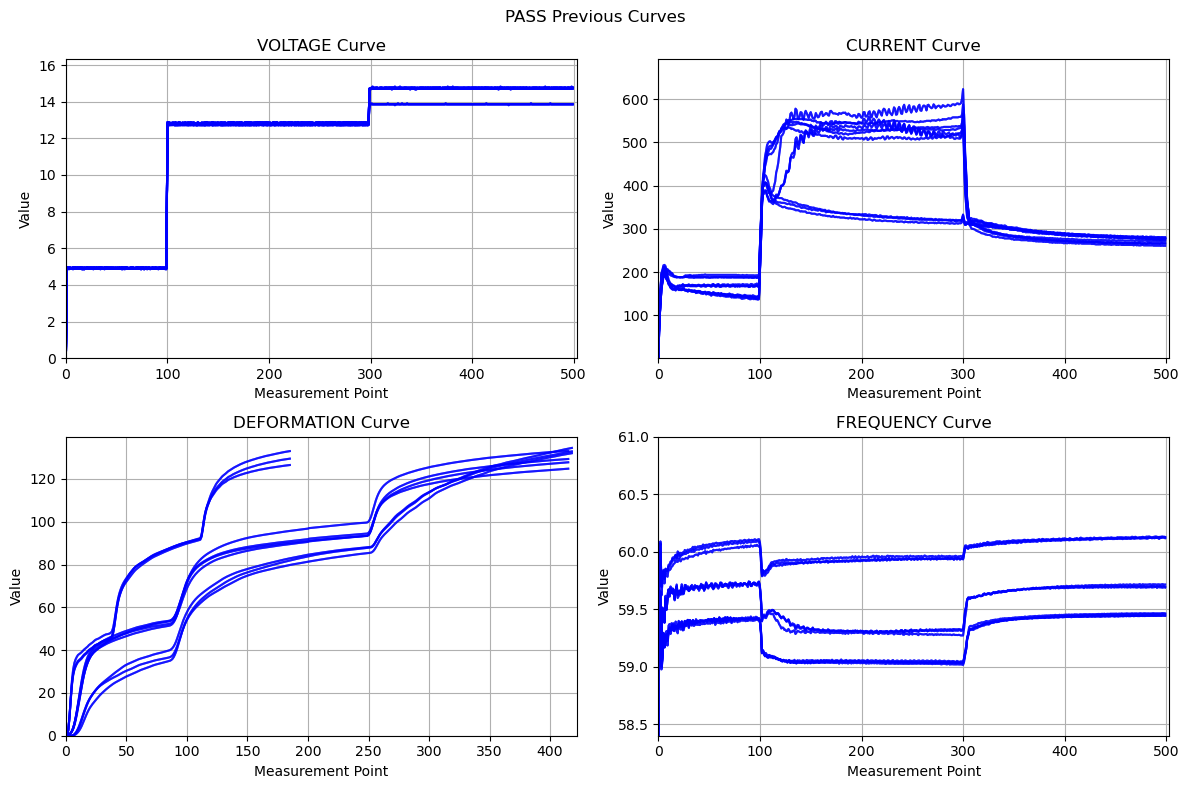

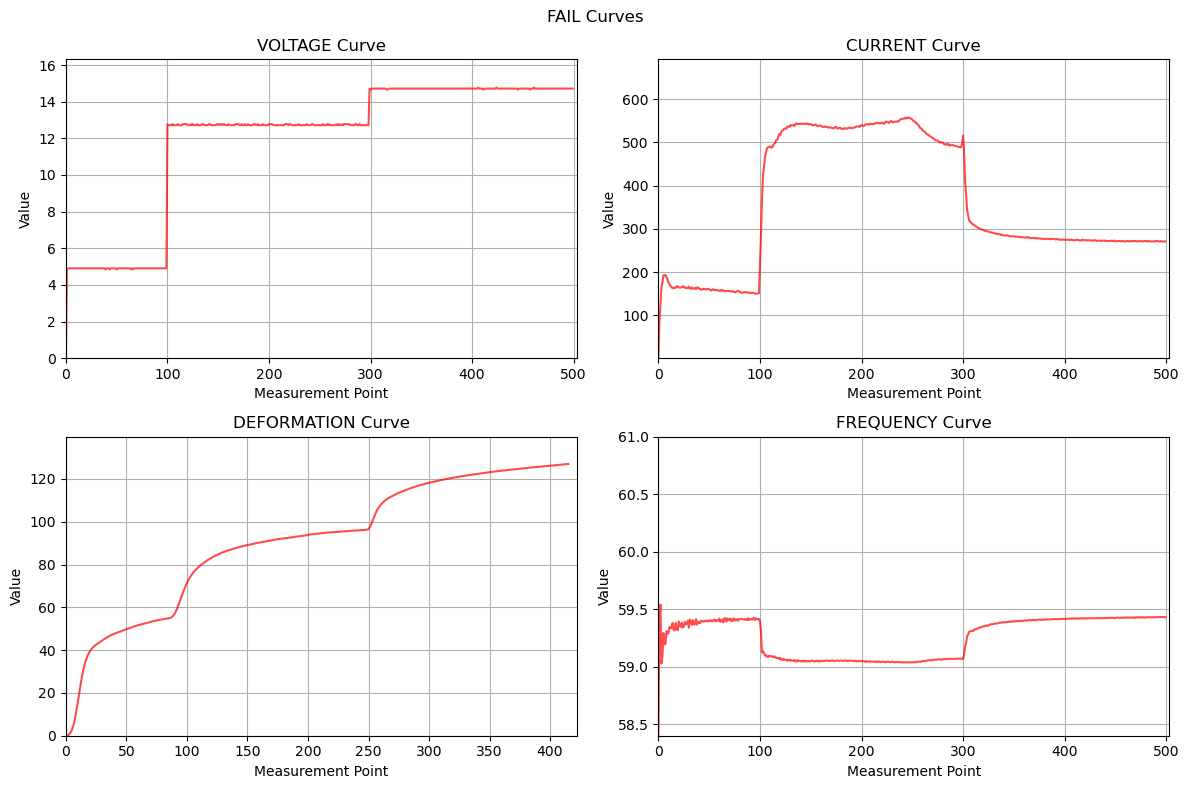

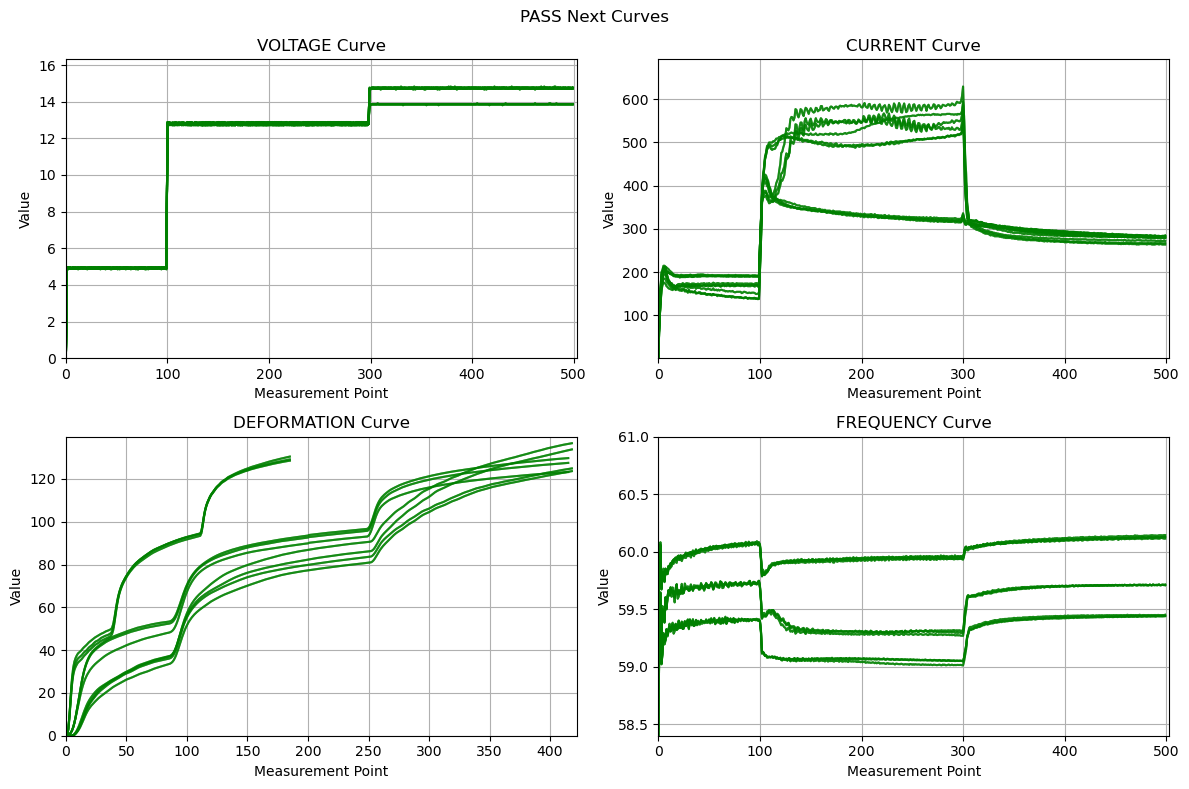

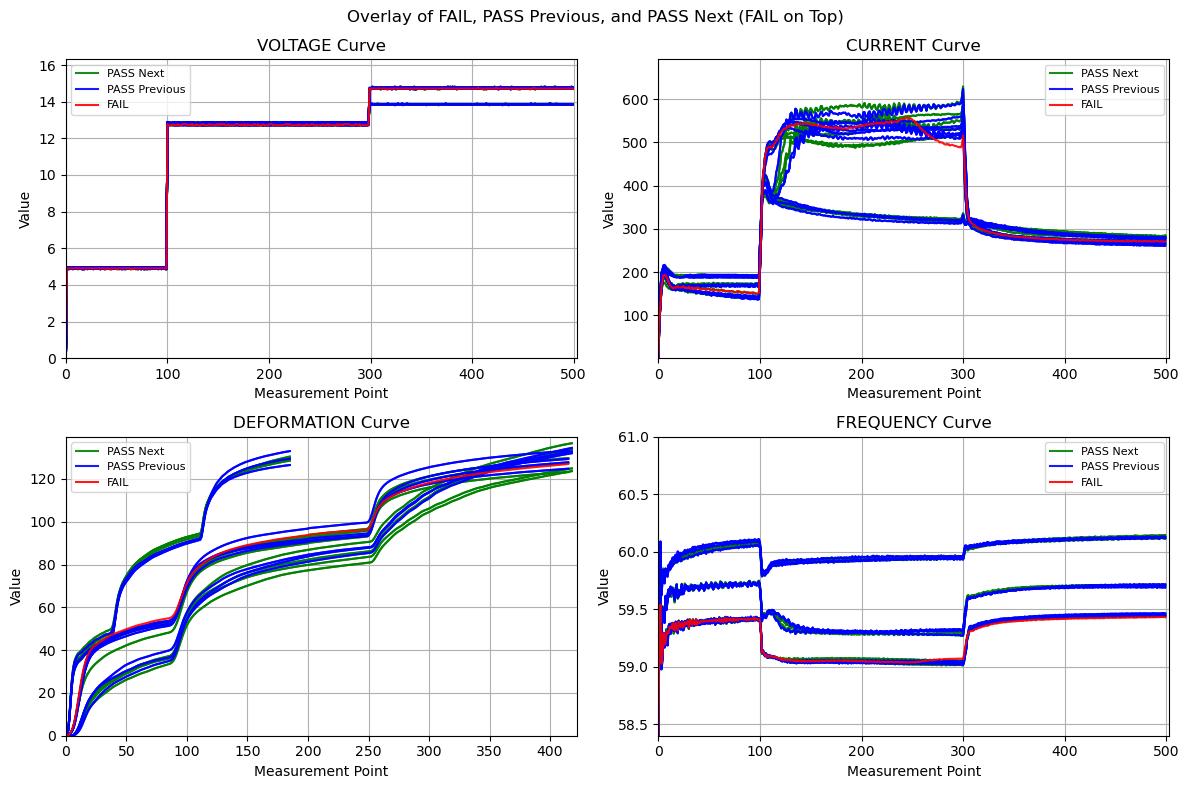

In [45]:
# ==== 繪製獨立圖 ====
plot_graph(wirebond_dfs_dict_prev, "PASS Previous Curves", "blue")
plot_graph(wirebond_dfs_dict_fail, "FAIL Curves", "red")
plot_graph(wirebond_dfs_dict_next, "PASS Next Curves", "green")

# ==== 疊加圖（FAIL 在最上面） ====
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

datasets = {"PASS Next": ("green", wirebond_dfs_dict_next), "PASS Previous": ("blue", wirebond_dfs_dict_prev), "FAIL": ("red", wirebond_dfs_dict_fail)}

for i, (curve_type, _) in enumerate(wirebond_dfs_dict_fail.items()):
    ax = axes[i]
    x_max, y_min, y_max = xy_limits[curve_type]

    for label, (color, wirebond_dfs) in datasets.items():
        for wb, df in wirebond_dfs[curve_type].items():
            curve_data = df.drop(columns=["SN", "WIRE_BOND", "CHIP_TYPE"]).astype(float)
            x_values = range(curve_data.shape[1])
            for row in curve_data.iterrows():
                ax.plot(x_values, row[1].values, color=color, alpha=0.9, label=label if label not in ax.get_legend_handles_labels()[1] else "")

    ax.set_title(f"{curve_type} Curve")
    ax.set_xlabel("Measurement Point")
    ax.set_ylabel("Value")
    ax.set_xlim(0, x_max)
    ax.set_ylim(y_min, y_max)
    ax.legend(fontsize=8)
    ax.grid(True)

plt.suptitle("Overlay of FAIL, PASS Previous, and PASS Next (FAIL on Top)")
plt.tight_layout()
plt.show()